In [105]:
import findspark

findspark.init()

import getpass
import pandas as pd
import pyspark
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, col, substring, when
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [106]:
start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.memory,4g
spark.executor.memory,4g
spark.app.startTime,1717715139533
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.sql.warehouse.dir,file:/users/home/mji57/Assignment_2/spark-warehouse
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32


## Data processing

In [107]:
#Question 2b - Load 1000 rows of the hdfs:///data/msd/main/summary/metadata.csv.gz file
msd_summary = spark.read.csv("hdfs:///data/msd/main/summary/*.csv.gz", header=True, inferSchema=True)

msd_summary.count()

2000000

In [4]:
msd_summary.printSchema()

root
 |-- analyzer_version: string (nullable = true)
 |-- artist_7digitalid: string (nullable = true)
 |-- artist_familiarity: string (nullable = true)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_mbid: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_playmeid: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- idx_artist_terms: string (nullable = true)
 |-- idx_similar_artists: string (nullable = true)
 |-- release: string (nullable = true)
 |-- release_7digitalid: string (nullable = true)
 |-- song_hotttnesss: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- track_7digitalid: string (nullable = true)



In [5]:
!hdfs dfs -du -h /data/msd

12.3 G   98.1 G   /data/msd/audio
30.1 M   241.0 M  /data/msd/genre
174.4 M  1.4 G    /data/msd/main
490.4 M  3.8 G    /data/msd/tasteprofile


In [6]:
!hdfs dfs -du -h /data/msd/audio

103.0 K  824.3 K  /data/msd/audio/attributes
12.2 G   97.8 G   /data/msd/audio/features
40.3 M   322.1 M  /data/msd/audio/statistics


In [7]:
!hdfs dfs -du -h /data/msd/audio/attributes

1.0 K   8.2 K    /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
671     5.2 K    /data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
484     3.8 K    /data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
898     7.0 K    /data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
777     6.1 K    /data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
777     6.1 K    /data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
12.0 K  96.2 K   /data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
9.8 K   78.0 K   /data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
1.4 K   10.9 K   /data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
34.1 K  272.8 K  /data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
3.8 K   30.8 K   /data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
9.8 K   78.0 K   /data/msd/audio/attributes/msd-trh-v1.0.attributes.csv
27.6 K  221.2 

In [8]:
!hdfs dfs -du -h /data/msd/audio/features

65.5 M   524.2 M  /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   /data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    /data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   /data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    /data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   /data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G   /data/msd/audio/features/msd-tssd-v1.0.csv


In [9]:
!hdfs dfs -du -h /data/msd/audio/statistics

40.3 M  322.1 M  /data/msd/audio/statistics/sample_properties.csv.gz


In [10]:
!hdfs dfs -du -h /data/msd/genre

11.1 M  88.7 M  /data/msd/genre/msd-MAGD-genreAssignment.tsv
8.4 M   67.3 M  /data/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  85.0 M  /data/msd/genre/msd-topMAGD-genreAssignment.tsv


In [11]:
!hdfs dfs -du -h /data/msd/main

174.4 M  1.4 G  /data/msd/main/summary


In [12]:
!hdfs dfs -du -h /data/msd/main/summary

55.9 M   447.5 M  /data/msd/main/summary/analysis.csv.gz
118.5 M  947.7 M  /data/msd/main/summary/metadata.csv.gz


In [13]:
!hdfs dfs -du -h /data/msd/tasteprofile

2.0 M    16.2 M  /data/msd/tasteprofile/mismatches
488.4 M  3.8 G   /data/msd/tasteprofile/triplets.tsv


In [14]:
!hdfs dfs -du -h /data/msd/tasteprofile/mismatches

89.2 K  713.6 K  /data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
1.9 M   15.5 M   /data/msd/tasteprofile/mismatches/sid_mismatches.txt


In [15]:
!hdfs dfs -du -h /data/msd/tasteprofile/triplets.tsv

61.1 M  488.4 M  /data/msd/tasteprofile/triplets.tsv/part-00000.tsv.gz
61.1 M  488.6 M  /data/msd/tasteprofile/triplets.tsv/part-00001.tsv.gz
61.1 M  488.9 M  /data/msd/tasteprofile/triplets.tsv/part-00002.tsv.gz
61.1 M  489.1 M  /data/msd/tasteprofile/triplets.tsv/part-00003.tsv.gz
61.0 M  488.3 M  /data/msd/tasteprofile/triplets.tsv/part-00004.tsv.gz
61.1 M  488.7 M  /data/msd/tasteprofile/triplets.tsv/part-00005.tsv.gz
61.1 M  488.8 M  /data/msd/tasteprofile/triplets.tsv/part-00006.tsv.gz
60.8 M  486.7 M  /data/msd/tasteprofile/triplets.tsv/part-00007.tsv.gz


In [108]:
tastep_trip_schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id", StringType(), True),
    StructField("play_count", IntegerType(), True)
])
conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
no_of_partitions = 4 * N * M
tastep_triplet = spark.read.csv("hdfs:///data/msd/tasteprofile/triplets.tsv", header=False, schema=tastep_trip_schema, sep = '\t').repartition(no_of_partitions)

tastep_triplet.show()
tastep_triplet.cache()

+--------------------+------------------+----------+
|             user_id|           song_id|play_count|
+--------------------+------------------+----------+
|ae4d21862db75b3cd...|SOOCMIB12A8C13E465|         5|
|bc2066eda369e411b...|SOOXDVF12A6D4FB4AD|         1|
|2bf302479a335436d...|SOFBOXR12A6310F0FC|         3|
|ba30b82fb562ac0ea...|SOPIBLV12A8C136C2A|         6|
|80779cf1be0cf7ea2...|SOQCIQX12A8C13B272|         2|
|5a502c3f2ce754b88...|SOJMITH12A8C13B6E5|         1|
|7c9dfcfbf7427c52d...|SOUEGBF12AB017EFD5|         1|
|7df8f300923df6260...|SOSXJHF12AB0181A1B|         1|
|8efaa70c0ffb38fce...|SOFQTHB12A8C1447C9|         6|
|0d8ad6dc1fc6b2a0d...|SOSBMZB12A6D4FB47A|         1|
|e206d522d0a9c9ca4...|SOTSHYT12A8C142868|         2|
|b0e41fe8a7474c3e0...|SOFSSYS12AB017E1B6|        11|
|1bc2271cbf82c888f...|SOEJRKN12A6D4F9796|         1|
|fc5b48e1a04a0e23d...|SOBJDDA12A6BD53159|         1|
|607306d594aff87cf...|SOIVZOS12A58A7CB82|         3|
|5d07e7bce84ec4657...|SOXTJZM12A8C135404|     

DataFrame[user_id: string, song_id: string, play_count: int]

In [93]:
#Question 1b
# Load each dataset 
msd_summary = spark.read.csv("hdfs:///data/msd/main/summary/*.csv.gz", header=True, inferSchema=True)
print("Million Song Dataset - Summary Count :", msd_summary.count())

msd_audio_attr = spark.read.csv("hdfs:///data/msd/audio/attributes/*.csv", header=False, inferSchema=True)
print("Million Song Dataset - Audio Attribute Count :", msd_audio_attr.count())

msd_audio_featr = spark.read.csv("hdfs:///data/msd/audio/features/*.csv", header=False, inferSchema=True)
print("Million Song Dataset - Audio Feature Count :", msd_audio_featr.count())

msd_audio_statistics = spark.read.csv("hdfs:///data/msd/audio/statistics/*.csv.gz", header=True, inferSchema=True)
print("Million Song Dataset - Audio Statistics Count :", msd_audio_statistics.count())

print("Million Song Dataset - Taste Profile Triplets Count :", tastep_triplet.count())

msd_tastep_mismatch = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/*.txt")
print("Million Song Dataset - Taste Profile Mismatch Count :", msd_tastep_mismatch.count())

msd_genre = spark.read.csv("hdfs:///data/msd/genre/*.tsv", header=False, sep="\t")
print("Million Song Dataset - Genre Count :", msd_genre.count())


Million Song Dataset - Summary Count : 2000000
Million Song Dataset - Audio Attribute Count : 3929
Million Song Dataset - Audio Feature Count : 12927867
Million Song Dataset - Audio Statistics Count : 992865
Million Song Dataset - Taste Profile Triplets Count : 48373586
Million Song Dataset - Taste Profile Mismatch Count : 20032
Million Song Dataset - Genre Count : 1103077


In [94]:
msd_summary_unique_songs = msd_summary.select("song_id").distinct().count()
print("Million Song Dataset Summary Metadata - Unique Songs Count :", msd_summary_unique_songs)

msd_trip_unique_songs = tastep_triplet.select("song_id").distinct().count()
print("Million Song Dataset Tasteprofile Triplets - Unique Songs Count :", msd_trip_unique_songs)

Million Song Dataset Summary Metadata - Unique Songs Count : 998964
Million Song Dataset Tasteprofile Triplets - Unique Songs Count : 384546


In [109]:
#Question 2a To ensure data consistency
tastep_mismatch = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/*.txt").rdd

def construct_mismatch_dataframe(line):
    match = re.match(r'.*<(.*?) (.*?)>.*', line[0])
    if match:
        return match.group(2), match.group(1)
    else:
        return None

tastep_mismatch = tastep_mismatch.map(construct_mismatch_dataframe).filter(lambda x: x is not None)
tastep_mismatch = tastep_mismatch.toDF(["track_id", "song_id"])

tastep_mismatch = tastep_mismatch.distinct()
tastep_mismatch.count()

19459

In [110]:
#2a continued
valid_tastep = tastep_triplet.join(tastep_mismatch, on = "song_id", how = "leftanti")
print("Count of mismatch tasteprofile :", valid_tastep.count())
print("Count of tasteprofile triplets :", tastep_triplet.count()) 

Count of mismatch tasteprofile : 45785819
Count of tasteprofile triplets : 48373586


In [36]:
#Question 2b
#Path to the attributes directory
path_audio_attr = "hdfs:///data/msd/audio/attributes"
path_audio_featur = "hdfs:///data/msd/audio/features"

# List of attribute files without extensions
audio_filename = [
    "msd-jmir-area-of-moments-all-v1.0",
    "msd-jmir-lpc-all-v1.0",
    "msd-jmir-methods-of-moments-all-v1.0",
    "msd-jmir-mfcc-all-v1.0",
    "msd-jmir-spectral-all-all-v1.0",
    "msd-jmir-spectral-derivatives-all-all-v1.0",
    "msd-marsyas-timbral-v1.0",
    "msd-mvd-v1.0",
    "msd-rh-v1.0",
    "msd-rp-v1.0",
    "msd-ssd-v1.0",
    "msd-trh-v1.0",
    "msd-tssd-v1.0"
]

# Function to load attribute files using PySpark
def load_audio_attributes(file):
    audio_attr = spark.read.csv(f"{path_audio_attr}/{file}.attributes.csv", header=None)
    audio_attr = audio_attr.toDF('attribute_name', 'attribute_type')
    return audio_attr

# Read and parse the attribute files using PySpark
audio_attr = {file: load_audio_attributes(file) for file in audio_filename}

# Mapping from attribute types to PySpark SQL types
audio_datyp = {
    'real': DoubleType(),
    'NUMERIC': DoubleType(),
    'float': DoubleType(),
    'string': StringType(),
    'STRING': StringType(),
}

def type_of_map(type_of_attr):
    return audio_datyp.get(type_of_attr.lower(), StringType())  

def create_attribute_dataframe(attr_dataframe):
    fields = [StructField(row['attribute_name'], type_of_map(row['attribute_type']), True) for row in attr_dataframe.collect()]
    return StructType(fields)

audio_schemas = {file: create_attribute_dataframe(df) for file, df in audio_attr.items()}

# Load the audio feature datasets using the created schemas
datasets = {}

for file in audio_filename:
    feature_file_path = f"{path_audio_featur}/{file}.csv"
    feature_schema = audio_schemas[file]
    audio_feature = spark.read.csv(feature_file_path, schema= feature_schema, header=True, sep=',')
    datasets[file] = audio_feature

# Display the first few rows of each loaded DataFrame to verify
for file, audio_feature_data in datasets.items():
    print(f"Showing data for: {file}")
    audio_feature_data.show(5)


Showing data for: msd-jmir-area-of-moments-all-v1.0
+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+---------------

+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------+
|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|         MSD_TRACKID|
+----------------------------------------------+----------------------------------------------+-----------------------------

+----------------------------------------------+---------------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-------------------------------------------+-----------------------------------+----------------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------------------+--------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Rolloff_Point_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Ene

+---------------------------------------------------------------------+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+
|component_0|component_1|component_2|component_3|component_4|component_5|component_6|component_7|component_8|component_9|component_10|component_11|component_12|component_13|component_14|component_15|componen

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------

## Audio Similarity

In [48]:
#Question 1a
audio_file_mfcc = datasets["msd-jmir-mfcc-all-v1.0"]

audio_mfcc_clmn = [field.name for field in audio_file_mfcc.schema.fields if isinstance(field.dataType, DoubleType)]

audio_corr_matrix = []
for i in range(len(audio_mfcc_clmn)):
    for j in range(i + 1, len(audio_mfcc_clmn)):
        t1 = audio_mfcc_clmn[i]
        t2 = audio_mfcc_clmn[j]
        corr_value = audio_file_mfcc.stat.corr(t1, t2)
        audio_corr_matrix.append((t1, t2, corr_value))

descrip_stats = audio_file_mfcc.select(audio_mfcc_clmn).describe()
descrip_stats.show() 

for t1, t2, value in audio_corr_matrix:
    print(f"Correlation between {t1} and {t1}: {value:.2f}")

feature_corr = [(t1, t2, value) for t1, t2, value in audio_corr_matrix if abs(value) > 0.7]

print("\nStrongly Correlated Features:")
for t1, t2, value in feature_corr:
    print(f"Strong correlation ({value:.2f}) between {t1} and {t2}")

+-------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|summary|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overall_Standard_Deviat

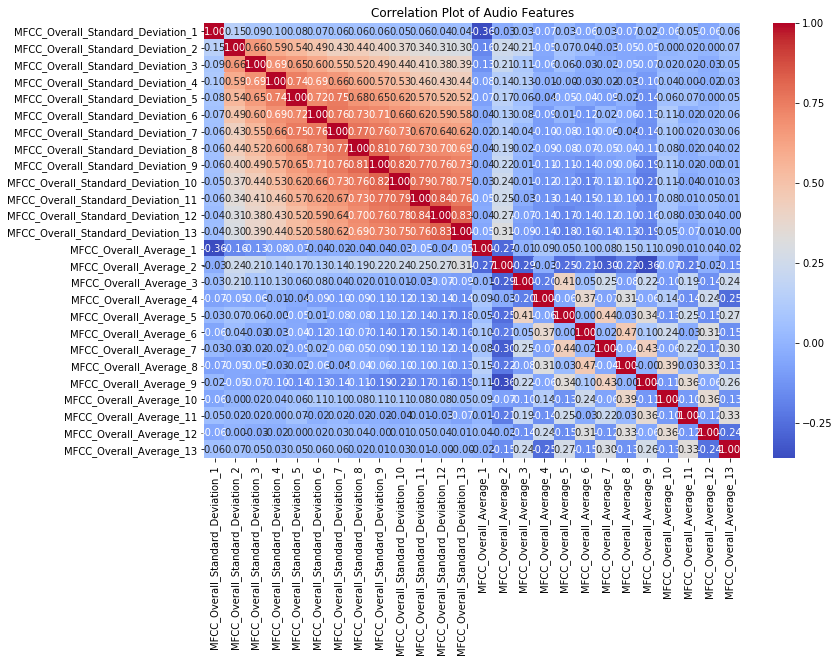

In [38]:
#Draw a heat map with the correlation

correlation_matrix = audio_file_mfcc.toPandas().corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Audio Features')
plt.show()

+------------------+--------------+
|               _c0|           _c1|
+------------------+--------------+
|TRAAAAK128F9318786|      Pop_Rock|
|TRAAAAV128F421A322|      Pop_Rock|
|TRAAAAW128F429D538|           Rap|
|TRAAABD128F429CF47|      Pop_Rock|
|TRAAACV128F423E09E|      Pop_Rock|
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|         Vocal|
|TRAAAEF128F4273421|      Pop_Rock|
|TRAAAEM128F93347B9|    Electronic|
|TRAAAFD128F92F423A|      Pop_Rock|
|TRAAAFP128F931B4E3|           Rap|
|TRAAAGR128F425B14B|      Pop_Rock|
|TRAAAGW12903CC1049|         Blues|
|TRAAAHD128F42635A5|      Pop_Rock|
|TRAAAHE12903C9669C|      Pop_Rock|
|TRAAAHJ128F931194C|      Pop_Rock|
|TRAAAHZ128E0799171|           Rap|
|TRAAAIR128F1480971|           RnB|
|TRAAAJG128F9308A25|          Folk|
|TRAAAMO128F1481E7F|     Religious|
+------------------+--------------+
only showing top 20 rows

+--------------+------+
|           _c1| count|
+--------------+------+
|     Religious|  8814|
|      Childre

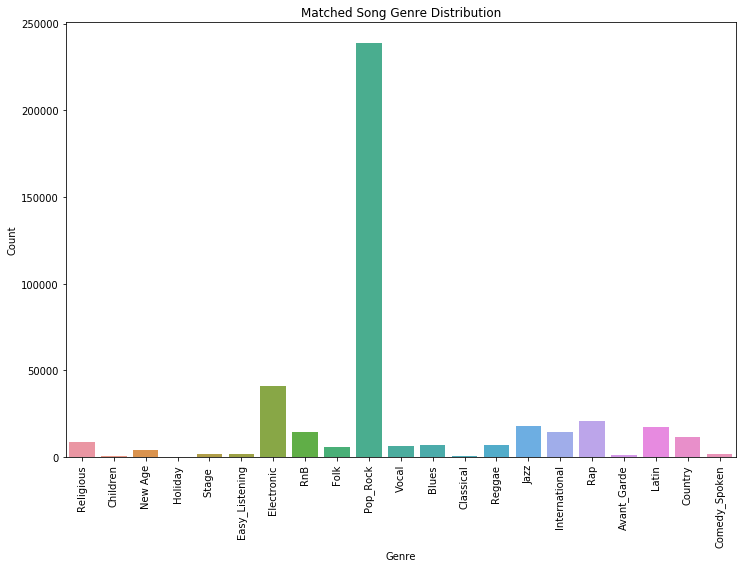

In [39]:
#Question 1b - Load MSD MAGD and visualise
msd_magd_genre = spark.read.csv("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv", header=False, sep="\t")
msd_magd_genre.show()

count_genre = msd_magd_genre.groupBy('_c1').count()
count_genre.show()

# Convert to Pandas DataFrame
count_genre_pandas = count_genre.toPandas()

# Plot the distribution
plt.figure(figsize=(12, 8))
sns.barplot(data=count_genre_pandas, x='_c1', y='count')
plt.xticks(rotation=90)
plt.title('Matched Song Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [40]:
msd_magd_genre.show()

+------------------+--------------+
|               _c0|           _c1|
+------------------+--------------+
|TRAAAAK128F9318786|      Pop_Rock|
|TRAAAAV128F421A322|      Pop_Rock|
|TRAAAAW128F429D538|           Rap|
|TRAAABD128F429CF47|      Pop_Rock|
|TRAAACV128F423E09E|      Pop_Rock|
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|         Vocal|
|TRAAAEF128F4273421|      Pop_Rock|
|TRAAAEM128F93347B9|    Electronic|
|TRAAAFD128F92F423A|      Pop_Rock|
|TRAAAFP128F931B4E3|           Rap|
|TRAAAGR128F425B14B|      Pop_Rock|
|TRAAAGW12903CC1049|         Blues|
|TRAAAHD128F42635A5|      Pop_Rock|
|TRAAAHE12903C9669C|      Pop_Rock|
|TRAAAHJ128F931194C|      Pop_Rock|
|TRAAAHZ128E0799171|           Rap|
|TRAAAIR128F1480971|           RnB|
|TRAAAJG128F9308A25|          Folk|
|TRAAAMO128F1481E7F|     Religious|
+------------------+--------------+
only showing top 20 rows



In [41]:
# Question 1c
msd_magd_genre = msd_magd_genre.withColumnRenamed('_c0', 'track_id').withColumnRenamed('_c1', 'genre')
audio_file_mfcc = audio_file_mfcc.withColumn('track_id', regexp_replace('MSD_TRACKID', "'", ""))
audio_genre_mfcc = audio_file_mfcc.join(msd_magd_genre, on="track_id", how="inner")
audio_genre_mfcc.show()

+------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+-------------+
|          track_id|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_

In [43]:
#Question 2b
audio_genre_mfcc_binary = audio_genre_mfcc.withColumn('labelElectronic', when(col('genre') == 'Electronic', 1).otherwise(0))

audio_genre_class_bal = audio_genre_mfcc_binary.groupBy('labelElectronic').count().collect()

total_audio_genre_count = sum(row['count'] for row in audio_genre_class_bal)
electronic_audio_genre_count = next(row['count'] for row in audio_genre_class_bal if row['labelElectronic'] == 1)
non_electronic_aud_gen_count = next(row['count'] for row in audio_genre_class_bal if row['labelElectronic'] == 0)

print(f"Total songs: {total_audio_genre_count}")
print(f"Electronic songs: {electronic_audio_genre_count} ({electronic_audio_genre_count / total_audio_genre_count:.2%})")
print(f"Non-Electronic songs: {non_electronic_aud_gen_count} ({non_electronic_aud_gen_count / total_audio_genre_count:.2%})")

audio_genre_mfcc_binary.show(5)


Total songs: 420616
Electronic songs: 40665 (9.67%)
Non-Electronic songs: 379951 (90.33%)
+------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------+---------------+
|          track_id|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_O

In [44]:
# Question 2c
train_data, test_data = audio_genre_mfcc_binary.randomSplit([0.8, 0.2], seed=42)

train_data_class_bal = train_data.groupBy('labelElectronic').count().collect()
test_data_class_bal = test_data.groupBy('labelElectronic').count().collect()

print("Training Set Class Distribution:")
for row in train_data_class_bal:
    print(f"Class {row['labelElectronic']}: {row['count']} ({row['count'] / sum(r['count'] for r in train_data_class_bal):.2%})")

print("\nTest Set Class Distribution:")
for row in test_data_class_bal:
    print(f"Class {row['labelElectronic']}: {row['count']} ({row['count'] / sum(r['count'] for r in test_data_class_bal):.2%})")

# Handle class imbalance using oversampling
major_class_imbalance = train_data.filter(col("labelElectronic") == 0)
minor_class_imbalance = train_data.filter(col("labelElectronic") == 1)

# Oversample the minority class
oversampl_minor_class = minor_class_imbalance.sample(withReplacement=True, fraction=major_class_imbalance.count() / minor_class_imbalance.count())

# Combine majority class with oversampled minority class
class_bal_train_data = major_class_imbalance.union(oversampl_minor_class)

# Verify the new class balance
balanced_train_class_distr = class_bal_train_data.groupBy('labelElectronic').count().collect()

print("\nBalanced Training Set Class Distribution:")
for row in balanced_train_class_distr:
    print(f"Class {row['labelElectronic']}: {row['count']} ({row['count'] / sum(r['count'] for r in balanced_train_class_distr):.2%})")

# Show the first few rows of the balanced training set
class_bal_train_data.show(5)

Training Set Class Distribution:
Class 0: 303924 (90.33%)
Class 1: 32544 (9.67%)

Test Set Class Distribution:
Class 0: 76027 (90.35%)
Class 1: 8121 (9.65%)

Balanced Training Set Class Distribution:
Class 0: 303924 (50.01%)
Class 1: 303757 (49.99%)
+------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----

In [52]:
#Question 2d 
class_bal_train_data = class_bal_train_data.drop("MSD_TRACKID")
inputcolumns = [col for col in class_bal_train_data.columns if col not in ['track_id', 'genre', 'labelElectronic']]

vec_assemblr = VectorAssembler(inputCols = inputcolumns, outputCol="features")
vector_assembled_train_data = vec_assemblr.transform(class_bal_train_data)
vector_assembled_test_data = vec_assemblr.transform(test_data)

logistic_regression = LogisticRegression(labelCol="labelElectronic", featuresCol="features")

log_reg_model = logistic_regression.fit(vector_assembled_train_data)

logistic_regression_prediction = log_reg_model.transform(vector_assembled_test_data)

algorithm_evaluator = MulticlassClassificationEvaluator(labelCol="labelElectronic", predictionCol="prediction", metricName="accuracy")
logistic_regression_accuracy = algorithm_evaluator.evaluate(logistic_regression_prediction)
print("Logistic Regression Model Accuracy:", logistic_regression_accuracy)


support_vector_machine = LinearSVC(labelCol="labelElectronic", featuresCol="features")

# Train the SVM model
support_vec_mach_model = support_vector_machine.fit(vector_assembled_test_data)

# Make predictions on the test data
support_vec_mach_predictions = support_vec_mach_model.transform(vector_assembled_test_data)

# Evaluate the model
support_vec_accuracy = algorithm_evaluator.evaluate(support_vec_mach_predictions)
print("Support Vector Machine Model Accuracy:", support_vec_accuracy)

#Decision Tree
decs_tree = DecisionTreeClassifier(labelCol="labelElectronic", featuresCol="features")

# Train the Decision Trees model
decs_tree_model = decs_tree.fit(vector_assembled_test_data)

# Make predictions on the test data
decs_tree_predictions = decs_tree_model.transform(vector_assembled_test_data)

# Evaluate the model
decs_tree_accuracy = algorithm_evaluator.evaluate(decs_tree_predictions)
print("Decision Trees Model Accuracy:", decs_tree_accuracy)



Logistic Regression Model Accuracy: 0.7583305604411276
Support Vector Machine Model Accuracy: 0.9035033512382944
Decision Trees Model Accuracy: 0.9093977278129011


In [49]:
vector_assembled_test_data.show()

+------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+-------------+---------------+--------------------+
|          track_id|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MF

In [53]:
#Question 2e
evaluator = MulticlassClassificationEvaluator(labelCol="labelElectronic", predictionCol="prediction")

# Logistic Regression Metrics
log_reg_accuracy = evaluator.evaluate(logistic_regression_prediction, {evaluator.metricName: "accuracy"})
log_reg_precision = evaluator.evaluate(logistic_regression_prediction, {evaluator.metricName: "weightedPrecision"})
log_reg_recall = evaluator.evaluate(logistic_regression_prediction, {evaluator.metricName: "weightedRecall"})
log_reg_f1 = evaluator.evaluate(logistic_regression_prediction, {evaluator.metricName: "f1"})

print("Logistic Regression Metrics:")
print(f"Accuracy: {log_reg_accuracy}")
print(f"Precision: {log_reg_precision}")
print(f"Recall: {log_reg_recall}")
print(f"F1 Score: {log_reg_f1}")

# SVM Metrics
supp_vecm_accuracy = evaluator.evaluate(support_vec_mach_predictions, {evaluator.metricName: "accuracy"})
supp_vecm_precision = evaluator.evaluate(support_vec_mach_predictions, {evaluator.metricName: "weightedPrecision"})
supp_vecm_recall = evaluator.evaluate(support_vec_mach_predictions, {evaluator.metricName: "weightedRecall"})
supp_vecm_f1 = evaluator.evaluate(support_vec_mach_predictions, {evaluator.metricName: "f1"})

print("\nSVM Metrics:")
print(f"Accuracy: {supp_vecm_accuracy}")
print(f"Precision: {supp_vecm_precision}")
print(f"Recall: {supp_vecm_recall}")
print(f"F1 Score: {supp_vecm_f1}")

# Decision Tree Metrics
decs_tree_accuracy = evaluator.evaluate(decs_tree_predictions, {evaluator.metricName: "accuracy"})
decs_tree_precision = evaluator.evaluate(decs_tree_predictions, {evaluator.metricName: "weightedPrecision"})
decs_tree_recall = evaluator.evaluate(decs_tree_predictions, {evaluator.metricName: "weightedRecall"})
decs_tree_f1 = evaluator.evaluate(decs_tree_predictions, {evaluator.metricName: "f1"})

print("\nDecision Tree Metrics:")
print(f"Accuracy: {decs_tree_accuracy}")
print(f"Precision: {decs_tree_precision}")
print(f"Recall: {decs_tree_recall}")
print(f"F1 Score: {decs_tree_f1}")

Logistic Regression Metrics:
Accuracy: 0.7583305604411276
Precision: 0.8909680655643762
Recall: 0.7583305604411275
F1 Score: 0.8036525210022312

SVM Metrics:
Accuracy: 0.9035033512382944
Precision: 0.9128150651193009
Recall: 0.9035033512382945
F1 Score: 0.8577128502547111

Decision Tree Metrics:
Accuracy: 0.9093977278129011
Precision: 0.8880077316046701
Recall: 0.9093977278129011
F1 Score: 0.8865911996184058


In [54]:
print(logistic_regression.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: labelElectronic)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimiz

In [55]:
msd_magd_genre.show()

+------------------+--------------+
|          track_id|         genre|
+------------------+--------------+
|TRAAAAK128F9318786|      Pop_Rock|
|TRAAAAV128F421A322|      Pop_Rock|
|TRAAAAW128F429D538|           Rap|
|TRAAABD128F429CF47|      Pop_Rock|
|TRAAACV128F423E09E|      Pop_Rock|
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|         Vocal|
|TRAAAEF128F4273421|      Pop_Rock|
|TRAAAEM128F93347B9|    Electronic|
|TRAAAFD128F92F423A|      Pop_Rock|
|TRAAAFP128F931B4E3|           Rap|
|TRAAAGR128F425B14B|      Pop_Rock|
|TRAAAGW12903CC1049|         Blues|
|TRAAAHD128F42635A5|      Pop_Rock|
|TRAAAHE12903C9669C|      Pop_Rock|
|TRAAAHJ128F931194C|      Pop_Rock|
|TRAAAHZ128E0799171|           Rap|
|TRAAAIR128F1480971|           RnB|
|TRAAAJG128F9308A25|          Folk|
|TRAAAMO128F1481E7F|     Religious|
+------------------+--------------+
only showing top 20 rows



In [56]:
#Question 4b - Assuming msd_magd_genre is your DataFrame containing the genre column
# Select distinct genres
distinct_magd_genres = msd_magd_genre.select("genre").distinct()

# Collect distinct genres to the driver
distinct_magd_genres_list = [row.genre for row in distinct_magd_genres.collect()]

# Create a dictionary mapping genres to integer indices
magd_genre_index = {genre: index for index, genre in enumerate(distinct_magd_genres_list)}

# Broadcast the genre_to_index dictionary to all nodes for efficient join
broadcast_genre_index = spark.sparkContext.broadcast(magd_genre_index)

# Map genres to integer indices using a User Defined Function (UDF)
genre_index_udf = F.udf(lambda x: broadcast_genre_index.value[x])
msd_magd_ind = msd_magd_genre.withColumn("genre_index", genre_index_udf(msd_magd_genre["genre"]))

# Print the mapping of genres to integer indices
print("Genre Index Mapping:")
print(magd_genre_index)

msd_magd_ind.show()

Genre Index Mapping:
{'Religious': 0, 'Children': 1, 'New Age': 2, 'Holiday': 3, 'Stage ': 4, 'Easy_Listening': 5, 'Electronic': 6, 'RnB': 7, 'Folk': 8, 'Pop_Rock': 9, 'Vocal': 10, 'Blues': 11, 'Classical': 12, 'Reggae': 13, 'Jazz': 14, 'International': 15, 'Rap': 16, 'Avant_Garde': 17, 'Latin': 18, 'Country': 19, 'Comedy_Spoken': 20}
+------------------+--------------+-----------+
|          track_id|         genre|genre_index|
+------------------+--------------+-----------+
|TRAAAAK128F9318786|      Pop_Rock|          9|
|TRAAAAV128F421A322|      Pop_Rock|          9|
|TRAAAAW128F429D538|           Rap|         16|
|TRAAABD128F429CF47|      Pop_Rock|          9|
|TRAAACV128F423E09E|      Pop_Rock|          9|
|TRAAADT12903CCC339|Easy_Listening|          5|
|TRAAAED128E0783FAB|         Vocal|         10|
|TRAAAEF128F4273421|      Pop_Rock|          9|
|TRAAAEM128F93347B9|    Electronic|          6|
|TRAAAFD128F92F423A|      Pop_Rock|          9|
|TRAAAFP128F931B4E3|           Rap|    

In [57]:
msd_magd_genre.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)



In [58]:
msd_magd_ind = msd_magd_ind.withColumn("genre_index", col("genre_index").cast("integer"))
msd_magd_ind.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_index: integer (nullable = true)



In [61]:
#Imbalanced classes
from pyspark.ml import Pipeline

input_columns = [col for col in msd_magd_ind.columns if col not in ['track_id', 'genre']]

# Assemble features
vec_assemblr = VectorAssembler(inputCols=input_columns, outputCol="features")

# Define Logistic Regression classifier
log_reg = LogisticRegression(labelCol="genre_index", featuresCol="features", maxIter=10)

# Define pipeline
pipeline_vec_assem = Pipeline(stages=[vec_assemblr, log_reg])

# Oversample minority classes
count_max_genre = msd_magd_ind.groupBy("genre_index").count().agg({"count": "max"}).collect()[0][0]
oversampled_list = []
for genre, count in msd_magd_ind.groupBy("genre_index").count().collect():
    if count < count_max_genre:
        oversampled_genre_data = msd_magd_ind.filter(col("genre_index") == genre).sample(True, count_max_genre / count, seed=123)
        oversampled_list.append(oversampled_genre_data)

# Combine oversampled data for all genres
oversampled_data = oversampled_list[0]
for i in range(1, len(oversampled_list)):
    oversampled_data = oversampled_data.unionAll(oversampled_list[i])

# Split oversampled data into train and test sets
train_data, test_data = oversampled_data.randomSplit([0.8, 0.2], seed=1234)

# Fit pipeline to oversampled training data
log_reg_model = pipeline_vec_assem.fit(train_data)

# Evaluate model on test data
predictions = log_reg_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.700486402320313
Precision: 0.5673687181229152
Recall: 0.700486402320313
F1 Score: 0.6089810644635267


In [62]:
#Question 4c

input_columns = [col for col in msd_magd_ind.columns if col not in ['track_id', 'genre']]

# Assemble features
vec_assemblr = VectorAssembler(inputCols=input_columns, outputCol="features")

# Define Logistic Regression classifier
log_reg = LogisticRegression(labelCol="genre_index", featuresCol="features", maxIter=10)

# Define pipeline
pipeline_vec_assem = Pipeline(stages=[vec_assemblr, log_reg])

# Oversample minority classes
count_max_genre = msd_magd_ind.groupBy("genre_index").count().agg({"count": "max"}).collect()[0][0]
oversampled_list = []
for row in msd_magd_ind.groupBy("genre_index").count().collect():
    genre, count = row['genre_index'], row['count']
    oversampled_genre_data = msd_magd_ind.filter(col("genre_index") == genre)
    if count < count_max_genre:
        oversampled_genre_data = oversampled_genre_data.sample(True, count_max_genre / count, seed=123)
    oversampled_list.append(oversampled_genre_data)

# Combine oversampled data for all genres
oversampled_data = oversampled_list[0]
for i in range(1, len(oversampled_list)):
    oversampled_data = oversampled_data.union(oversampled_list[i])

# Split oversampled data into train and test sets
train_data, test_data = oversampled_data.randomSplit([0.8, 0.2], seed=1234)

# Fit pipeline to oversampled training data
log_reg_model = pipeline_vec_assem.fit(train_data)

# Evaluate model on test data
predictions = log_reg_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction")

# Calculate metrics per genre
def evaluate_model_per_genre(predictions, num_classes):
    genre_metrics = {}
    
    for genre_ind in range(num_classes):
        genre_predictions = predictions.filter(predictions["genre_index"] == genre_ind)
        genre_accuracy = evaluator.evaluate(genre_predictions, {evaluator.metricName: "accuracy"})
        genre_precision = evaluator.evaluate(genre_predictions, {evaluator.metricName: "weightedPrecision"})
        genre_recall = evaluator.evaluate(genre_predictions, {evaluator.metricName: "weightedRecall"})
        genre_f1 = evaluator.evaluate(genre_predictions, {evaluator.metricName: "f1"})
        
        genre_metrics[genre_ind] = {
            "Accuracy": genre_accuracy,
            "Precision": genre_precision,
            "Recall": genre_recall,
            "F1 Score": genre_f1
        }
    
    return genre_metrics

num_classes = msd_magd_ind.select("genre_index").distinct().count()
log_reg_genre_metrics = evaluate_model_per_genre(predictions, num_classes)

# Print genre-wise metrics
for genre_index, metrics in log_reg_genre_metrics.items():
    print(f"Genre {genre_index}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")

# Print overall metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Genre 0:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 1:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 2:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 3:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Genre 4:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 5:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 6:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 7:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 8:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 9:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 10:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 11:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Scor

In [63]:
#To check for class balance
class_distribution = oversampled_data.groupBy("genre_index").count().orderBy("genre_index").collect()

# Print class distribution
print("Class Distribution:")
for row in class_distribution:
    genre_index = row["genre_index"]
    count = row["count"]
    print("Genre:", genre_index, "Count:", count)


Class Distribution:
Genre: 0 Count: 238150
Genre: 1 Count: 239263
Genre: 2 Count: 239041
Genre: 3 Count: 238799
Genre: 4 Count: 238821
Genre: 5 Count: 238671
Genre: 6 Count: 238280
Genre: 7 Count: 238200
Genre: 8 Count: 238435
Genre: 9 Count: 238786
Genre: 10 Count: 238251
Genre: 11 Count: 238163
Genre: 12 Count: 239637
Genre: 13 Count: 238261
Genre: 14 Count: 238163
Genre: 15 Count: 238334
Genre: 16 Count: 238261
Genre: 17 Count: 239501
Genre: 18 Count: 238207
Genre: 19 Count: 238355
Genre: 20 Count: 239206


## Song Recommendation

In [100]:
#Question 1b
valid_tastep_unique_song = valid_tastep.select("song_id").distinct().count()
print("Unique songs in taste profile :", valid_tastep_unique_song)
valid_tastep_unique_users = valid_tastep.select("user_id").distinct().count()
print("Unique users in taste profile :", valid_tastep_unique_users)

Unique songs in taste profile : 378205
Unique users in taste profile : 1019318


In [65]:
#Question 1c
songs_diff_user = valid_tastep.groupBy("user_id").count()
active_user = songs_diff_user.orderBy(col("count").desc()).first()["user_id"]
active_user_songs = valid_tastep.filter(col("user_id") == active_user).select("song_id").distinct().count()
tot_uniq_songs = valid_tastep.select("song_id").distinct().count()
percent_tot_uniq_songs = (active_user_songs / tot_uniq_songs) * 100
print(f"Number of different songs played by the most active user: {active_user_songs}")
print(f"Total number of unique songs in the dataset: {tot_uniq_songs}")
print(f"Percentage: {percent_tot_uniq_songs:.2f}%")

Number of different songs played by the most active user: 4316
Total number of unique songs in the dataset: 378205
Percentage: 1.14%


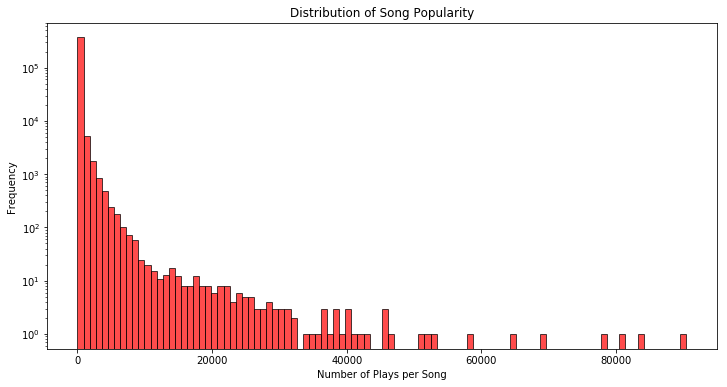

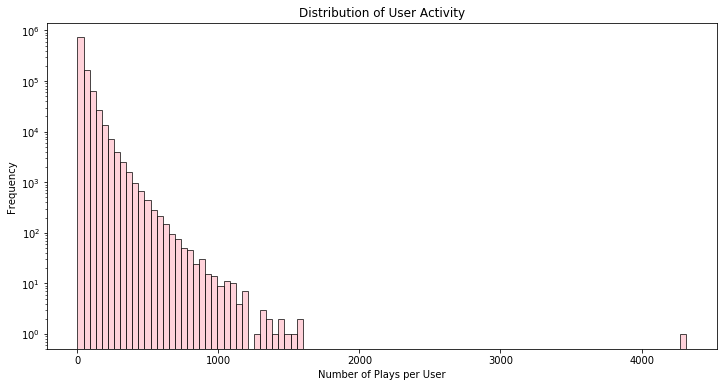

Description of Song Popularity Distribution:
count    378205.000000
mean        121.060851
std         748.734937
min           1.000000
25%           4.000000
50%          13.000000
75%          50.000000
max       90444.000000
Name: count, dtype: float64

Description of User Activity Distribution:
count    1.019318e+06
mean     4.491809e+01
std      5.490160e+01
min      3.000000e+00
25%      1.500000e+01
50%      2.600000e+01
75%      5.300000e+01
max      4.316000e+03
Name: count, dtype: float64


In [97]:
#Question 1d - Calculate counts of user plays per song
user_count_per_song = valid_tastep.groupBy("song_id").count().orderBy(col("count").desc()) 
user_count_per_song_pan = user_count_per_song.toPandas()

# Calculate counts of song plays per user
song_count_per_user = valid_tastep.groupBy("user_id").count().orderBy(col("count").desc())
song_count_per_user_pan = song_count_per_user.toPandas()

plt.figure(figsize=(12, 6))
plt.hist(user_count_per_song_pan['count'], bins=100, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Song Popularity')
plt.xlabel('Number of Plays per Song')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Distribution of user activity
plt.figure(figsize=(12, 6))
plt.hist(song_count_per_user_pan['count'], bins=100, color='pink', edgecolor='black', alpha=0.7)
plt.title('Distribution of User Activity')
plt.xlabel('Number of Plays per User')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale to better visualize the distribution
plt.show()

# Print descriptions of the distributions
print("Description of Song Popularity Distribution:")
print(user_count_per_song_pan['count'].describe())

print("\nDescription of User Activity Distribution:")
print(song_count_per_user_pan['count'].describe())

,total_song_plays,num_users
0,3.0,3
1,4.0,3
2,5.0,12
3,6.0,72
4,7.0,231
5,8.0,1053
6,9.0,3501
7,10.0,8454
8,11.0,10682
9,12.0,11720


,num_unique_songs,num_users
0,3.0,4
1,4.0,13
2,5.0,32
3,6.0,210
4,7.0,1229
5,8.0,6041
6,9.0,22050
7,10.0,50395
8,11.0,45814
9,12.0,42003


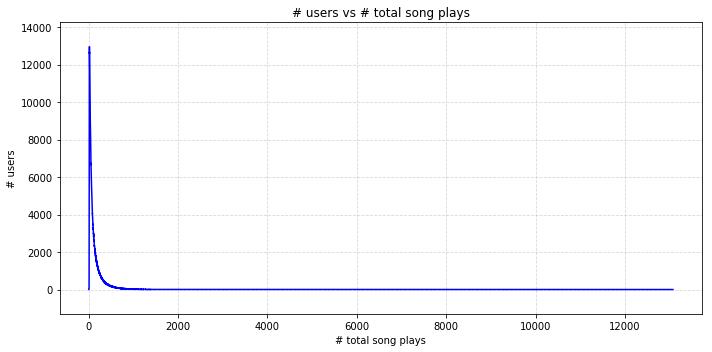

In [73]:
# Calculate counts of user plays per song
temp = (
    valid_tastep
    .groupBy(F.col("user_id"))
    .agg(
        F.sum("play_count").cast(DoubleType()).alias("total_song_plays"),
        F.count("song_id").cast(DoubleType()).alias("num_unique_songs")
    )
)

total_song_plays_user_counts = (
    temp
    .groupBy(F.col("total_song_plays"))
    .agg(
        F.count(F.col("user_id")).alias("num_users")
    )
    .repartition(1)
    .orderBy(F.col("total_song_plays"))
)

num_unique_songs_user_counts = (
    temp
    .groupBy(F.col("num_unique_songs"))
    .agg(
        F.count(F.col("user_id")).alias("num_users")
    )
    .repartition(1)
    .orderBy(F.col("num_unique_songs"))
)

total_song_plays_user_counts_local = total_song_plays_user_counts.toPandas()
num_unique_songs_user_counts_local = num_unique_songs_user_counts.toPandas()

display(total_song_plays_user_counts_local)
display(num_unique_songs_user_counts_local)

# Plot # users vs # total song plays

x = total_song_plays_user_counts_local["total_song_plays"]
y = total_song_plays_user_counts_local["num_users"]

# Plots

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, '-b')

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title(f"# users vs # total song plays")
ax.set_xlabel('# total song plays')
ax.set_ylabel('# users')

fig.tight_layout()


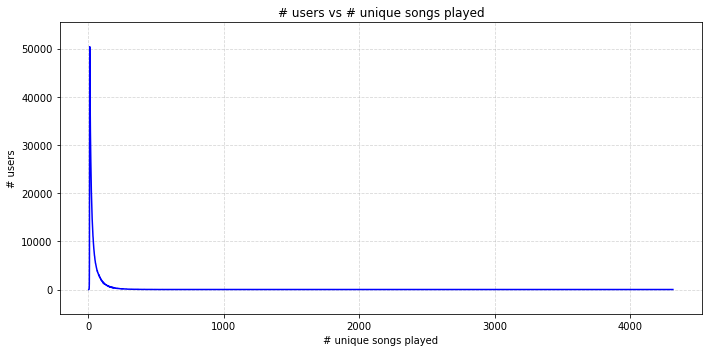

In [74]:
# Plot no of users vs no of total song plays

x = num_unique_songs_user_counts_local["num_unique_songs"]
y = num_unique_songs_user_counts_local["num_users"]

# Plots

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, '-b')

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title(f"# users vs # unique songs played")
ax.set_xlabel('# unique songs played')
ax.set_ylabel('# users')

fig.tight_layout()

,total_user_plays,num_songs
0,1.0,21856
1,2.0,16235
2,3.0,13268
3,4.0,11063
4,5.0,10530
5,6.0,9412
6,7.0,8360
7,8.0,7580
8,9.0,6909
9,10.0,6539


,num_unique_users,num_songs
0,1.0,31444
1,2.0,26259
2,3.0,21939
3,4.0,18819
4,5.0,16210
5,6.0,14343
6,7.0,12151
7,8.0,10916
8,9.0,9577
9,10.0,8594


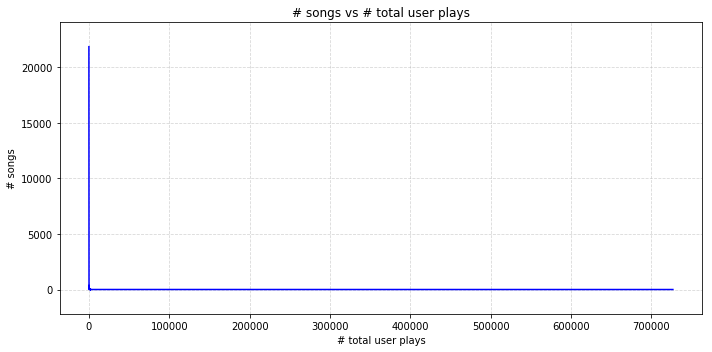

In [76]:
# Collect user counts for plotting

temp = (
    valid_tastep
    .groupBy(F.col("song_id"))
    .agg(
        F.sum("play_count").cast(DoubleType()).alias("total_user_plays"),
        F.count("user_id").cast(DoubleType()).alias("num_unique_users")
    )
)

total_user_plays_user_counts = (
    temp
    .groupBy(F.col("total_user_plays"))
    .agg(
        F.count(F.col("song_id")).alias("num_songs")
    )
    .repartition(1)
    .orderBy(F.col("total_user_plays"))
)

num_unique_users_user_counts = (
    temp
    .groupBy(F.col("num_unique_users"))
    .agg(
        F.count(F.col("song_id")).alias("num_songs")
    )
    .repartition(1)
    .orderBy(F.col("num_unique_users"))
)

total_user_plays_user_counts_local = total_user_plays_user_counts.toPandas()
num_unique_users_user_counts_local = num_unique_users_user_counts.toPandas()

display(total_user_plays_user_counts_local)
display(num_unique_users_user_counts_local)

# Plot no of users vs no of total song plays

x = total_user_plays_user_counts_local["total_user_plays"]
y = total_user_plays_user_counts_local["num_songs"]

# Plots

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, '-b')

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title(f"# songs vs # total user plays")
ax.set_xlabel('# total user plays')
ax.set_ylabel('# songs')

fig.tight_layout()

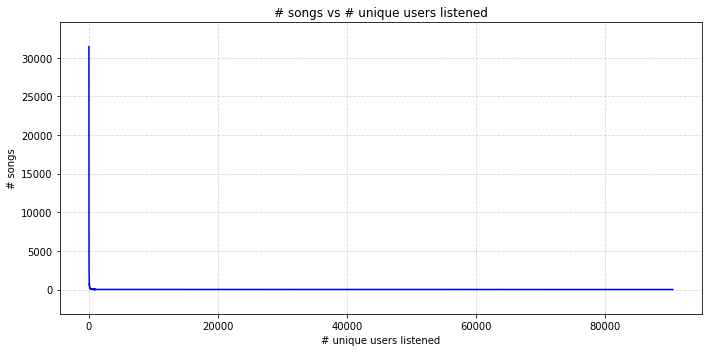

In [117]:
# Plot no of users vs no of total song plays

x = num_unique_users_user_counts_local["num_unique_users"]
y = num_unique_users_user_counts_local["num_songs"]


plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, '-b')

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title(f"# songs vs # unique users listened")
ax.set_xlabel('# unique users listened')
ax.set_ylabel('# songs')

fig.tight_layout()

In [114]:
#Question 2a - 
X = 1000  # Minimum number of plays for a song
Y = 100   # Minimum number of songs listened by a user

# Filter out users who have listened to fewer than 100 songs
Y_song_count_user = valid_tastep.groupBy("user_id").count()

refined_users = Y_song_count_user.filter(col("count") >= Y).select("user_id")

# Filter out songs that have been played fewer than 1000 times
X_song_count_user = valid_tastep.groupBy("song_id").count()
X_song_count_user = X_song_count_user.orderBy("count", ascending = False)

refined_songs = X_song_count_user.filter(col("count") >= X).select("song_id")

# Filter the original dataset based on valid users and songs
refined_dataset = valid_tastep.join(refined_users, "user_id", "inner").join(refined_songs, "song_id", "inner")
#Refined dataset contains only the plays where both the user and the song meet the minimum play criteria.
refined_dataset.show()
refined_dataset.count()


+------------------+--------------------+----------+
|           song_id|             user_id|play_count|
+------------------+--------------------+----------+
|SOABGOB12A6701D1FA|0603f3c2df49d54f9...|         3|
|SOABGOB12A6701D1FA|2e413772c7921e4fa...|         2|
|SOABGOB12A6701D1FA|354f5d8c74949cb19...|         1|
|SOABGOB12A6701D1FA|3c765aef977547e23...|         1|
|SOABGOB12A6701D1FA|53ec3e8dae87fb407...|         1|
|SOABGOB12A6701D1FA|70a162d3cfcb58502...|         1|
|SOABGOB12A6701D1FA|9d7835547da96ce5e...|         1|
|SOABGOB12A6701D1FA|aac037227c300e7ec...|         1|
|SOABGOB12A6701D1FA|b43af93b7af651e48...|         1|
|SOABGOB12A6701D1FA|b91b8e1780abb44e5...|         3|
|SOABGOB12A6701D1FA|dfd321c712b3e752d...|         1|
|SOABGOB12A6701D1FA|f0b135f8b135440f0...|         1|
|SOABGOB12A6701D1FA|f9ed26065153189f5...|         1|
|SOABGOB12A6701D1FA|0ab7442e65453bde8...|         2|
|SOABGOB12A6701D1FA|16cacfbd7968b6f47...|         3|
|SOABGOB12A6701D1FA|334d3341069fe77d5...|     

8142781

In [115]:
#Question 2b

train_data, test_data = refined_dataset.randomSplit([0.75, 0.25], seed=1234)

test_data_uniq_users = test_data.select("user_id").distinct()
train_data_uniq_users = train_data.select("user_id").distinct()

missing_users = test_data_uniq_users.join(train_data_uniq_users, on="user_id", how="left_anti")

# Moving all interactions of missing users from test set to training set
if missing_users.count() > 0:
    missing_user_interactions = test_data.join(missing_users, on="user_id", how="inner")
    refined_train_data = train_data.union(missing_user_interactions)
    test_data = test_data.subtract(missing_user_interactions)
else:
    refined_train_data = train_data

# To ensure that test set contains at least 25% of the plays
play_count_test_data = test_data.count() 
count_refined_data = refined_dataset.count()
if play_count_test_data < 0.25 * count_refined_data:
    required_plays = int(0.25 * count_refined_data - play_count_test_data)
    additional_plays = refined_train_data.sample(withReplacement=False, fraction=required_plays / refined_train_data.count())
    test_data = test_data.union(additional_plays)
    refined_train_data = refined_train_data.subtract(additional_plays)

# Final distribution check
play_count_train_data = refined_train_data.count()
play_count_test_data = test_data.count()

print(f"Total plays: {count_refined_data}")
print(f"Training set plays: {play_count_train_data} ({play_count_train_data / count_refined_data:.2%})")
print(f"Test set plays: {play_count_test_data} ({play_count_test_data / count_refined_data:.2%})")

Total plays: 8142781
Training set plays: 6106848 (75.00%)
Test set plays: 2035943 (25.00%)


In [69]:
output_train = "hdfs:///user/mji57/outputs/refined_train_data"
output_test = "hdfs:///user/mji57/outputs/test_data"

refined_train_data.write.mode("overwrite").parquet(output_train)
test_data.write.mode("overwrite").parquet(output_test)


In [111]:
output_direc_train = "hdfs:///user/mji57/outputs/refined_train_data"
output_direc_test = "hdfs:///user/mji57/outputs/test_data"
refined_train_data = spark.read.parquet(output_direc_train)
test_data = spark.read.parquet(output_direc_test)


In [112]:
refined_train_data.show()
test_data.show()

+------------------+--------------------+----------+
|           song_id|             user_id|play_count|
+------------------+--------------------+----------+
|SOAAROC12A6D4FA420|0f823b19d07f6b843...|         2|
|SOAAVUV12AB0186646|ea3fc3b87a87cad77...|         2|
|SOAAWEE12A6D4FBEC8|5d87e088bc145e59a...|         1|
|SOABJBU12A8C13F63F|bf0ef636bdb2fc94b...|         1|
|SOABQTG12A6701F3DB|82e11798383e61440...|         2|
|SOACERJ12A67AD865E|beea221e9df2af0b1...|         1|
|SOACKIA12A6D4F73D7|43306e45da8b20fb9...|         1|
|SOACPSU12A81C231EF|079c6c485c8c9b280...|        10|
|SOADISH12AB018DFAC|6f7ef533d63776a56...|         1|
|SOADJQJ12A8C141D38|2f88c640073cc96a0...|         4|
|SOADJQJ12A8C141D38|964f5620add35de77...|         8|
|SOADJQJ12A8C141D38|ed24a708bfa76393f...|         7|
|SOAFAXA12A58A7BB11|0b9dd116ff1596d22...|         3|
|SOAFAXA12A58A7BB11|689695ec48b54fc96...|         2|
|SOAFHIF12AB0184446|b51fdfccf441812ba...|         1|
|SOAFTRR12AF72A8D4D|2722f4fd8ec9e8786...|     

In [116]:
#Question 2c

user_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_numeric")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_id_numeric")

# Fit and transform the data
refined_train_data = user_indexer.fit(refined_train_data).transform(refined_train_data)
refined_train_data = song_indexer.fit(refined_train_data).transform(refined_train_data)

test_data = user_indexer.fit(test_data).transform(test_data)
test_data = song_indexer.fit(test_data).transform(test_data)

# Select only the required columns
refined_train_data = refined_train_data.select("user_id_numeric", "song_id_numeric", "play_count", "user_id", "song_id")
test_data = test_data.select("user_id_numeric", "song_id_numeric", "play_count", "user_id", "song_id")

# Ensure the DataFrame is cached to speed up processing
refined_train_data.cache()
test_data.cache()


alt_least_sq = ALS(
    userCol="user_id_numeric",
    itemCol="song_id_numeric",
    ratingCol="play_count",
    coldStartStrategy="drop"
)

param_grid_build = ParamGridBuilder() \
    .addGrid(alt_least_sq.maxIter, [5, 10, 15]) \
    .addGrid(alt_least_sq.regParam, [0.01, 0.1, 0.5]) \
    .build()

# To define evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="play_count",
    predictionCol="prediction"
)

# To define cross-validator
cross_validator = CrossValidator(
    estimator=alt_least_sq,
    estimatorParamMaps=param_grid_build,
    evaluator=evaluator,
    numFolds=5  
)

# Perform cross-validation
cv_model = cross_validator.fit(refined_train_data)

# Get the best model
best_model = cv_model.bestModel

# Generate predictions on the test set
predictions = best_model.transform(test_data)

rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Root-mean-square error = 6.003819090288927


In [119]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

user_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_numeric")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_id_numeric")

# Fit and transform the data
valid_tastep = user_indexer.fit(valid_tastep).transform(valid_tastep)
valid_tastep = song_indexer.fit(valid_tastep).transform(valid_tastep)

# Select only the required columns
valid_tastep = valid_tastep.select("user_id_numeric", "song_id_numeric", "play_count")

# Ensure the DataFrame is cached to speed up processing
valid_tastep.cache()

# Train the ALS model
alt_least_sq = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id_numeric",
    itemCol="song_id_numeric",
    ratingCol="play_count",
    implicitPrefs=True,
    coldStartStrategy="drop"
)
als_model = alt_least_sq.fit(refined_train_data)


In [121]:
#Question 2d

sample_users = test_data.select("user_id_numeric").distinct().limit(5)

recommendations = als_model.recommendForUserSubset(sample_users, 10)
recommendations.show(truncate=False)



+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id_numeric|recommendations                                                                                                                                                                        |
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|20323          |[{21, 0.48001882}, {101, 0.4582147}, {46, 0.45584106}, {133, 0.43759158}, {47, 0.42512193}, {161, 0.420046}, {171, 0.41637367}, {176, 0.39163005}, {197, 0.38564998}, {227, 0.3790973}]|
|60566          |[{7, 0.30434427}, {25, 0.26139578}, {12, 0.24622478}, {61, 0.24424188}, {1, 0.24028973}, {69, 0.24018069}, {97, 0.21279013}, {106, 0.21070346}, {37, 0.21065515}, {87, 0.208193

In [148]:
relevant = (
    test_data
    .groupBy("user_id_numeric")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_id_numeric"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
show_as_html(relevant)

root
 |-- user_id_numeric: double (nullable = false)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_id_numeric: double (nullable = false)



,user_id_numeric,relevant
0,6.0,"[(7, 3171.0), (7, 15.0), (6, 360.0), (6, 197.0..."
1,13.0,"[(10, 6493.0), (9, 3510.0), (8, 7285.0), (7, 2..."
2,99.0,"[(44, 6072.0), (10, 1536.0), (7, 40.0), (5, 32..."
3,106.0,"[(23, 330.0), (22, 194.0), (18, 591.0), (13, 3..."
4,122.0,"[(11, 1193.0), (6, 1091.0), (5, 2654.0), (5, 2..."
5,194.0,"[(74, 7085.0), (17, 2047.0), (13, 3495.0), (12..."
6,196.0,"[(13, 1556.0), (12, 5013.0), (10, 2850.0), (9,..."
7,209.0,"[(30, 139.0), (14, 112.0), (13, 138.0), (12, 3..."
8,215.0,"[(26, 7275.0), (15, 27.0), (11, 4750.0), (9, 0..."
9,350.0,"[(7, 222.0), (7, 126.0), (6, 1600.0), (5, 6898..."


In [147]:
recommendations.printSchema()

root
 |-- user_id_numeric: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_id_numeric: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [149]:
temp = (
    recommendations
    .select(
        F.col("user_id_numeric"),
        F.col("recommendations.song_id_numeric").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id_numeric"),
            F.col("relevant.song_id_numeric").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id_numeric",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- user_id_numeric: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,user_id_numeric,recommendations,relevant
0,7480,"[21.0, 46.0, 47.0, 101.0, 133.0, 161.0, 171.0,...","[934.0, 896.0, 630.0, 456.0, 263.0, 3564.0, 14..."
1,9935,"[133.0, 21.0, 45.0, 186.0, 171.0, 46.0, 161.0,...","[851.0, 3576.0, 4058.0, 7034.0, 6929.0, 6816.0..."
2,21431,"[11.0, 74.0, 194.0, 10.0, 292.0, 90.0, 45.0, 9...","[898.0, 7528.0, 1412.0, 637.0, 218.0, 126.0, 4..."
3,69452,"[39.0, 22.0, 11.0, 156.0, 0.0, 246.0, 315.0, 5...","[231.0, 1.0, 5149.0, 3202.0, 67.0, 16.0, 0.0, ..."
4,93815,"[192.0, 153.0, 187.0, 186.0, 211.0, 205.0, 216...","[6183.0, 6347.0, 5495.0, 7320.0, 4568.0, 228.0]"


In [150]:
from pyspark.ml.evaluation import RankingEvaluator
k = 10

song_evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precision_K = song_evaluator.evaluate(temp, {song_evaluator.metricName: "precisionAtK",            song_evaluator.k: k})
map_K       = song_evaluator.evaluate(temp, {song_evaluator.metricName: "meanAveragePrecisionAtK", song_evaluator.k: k})
ndcg_K      = song_evaluator.evaluate(temp, {song_evaluator.metricName: "ndcgAtK",                 song_evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precision_K:.5f}')
print(f'MAP @ K:       {map_K:.5f}')
print(f'NDCG @ K:      {ndcg_K:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.02000
MAP @ K:       0.00400
NDCG @ K:      0.01703



In [104]:
stop_spark()